In [66]:
# ПОДКЛЮЧЕНИЕ БИБЛИОТЕК
import requests
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv
from pathlib import Path

In [67]:
#создание папки для графиков
p = Path.cwd()
d = p / 'charts'
d.mkdir(exist_ok=True)

In [68]:
#обращение к файлу с исходными данными
load_dotenv()
DATE_BEGIN = os.getenv('DATE_BEGIN')
DATE_END = os.getenv('DATE_END')
API_URL = os.getenv('API_URL')

In [69]:
#обработка визитов
vis = requests.get(f'{API_URL}/visits?', params={'begin': DATE_BEGIN, 'end': DATE_END}) #мб косяк с адресом
df_vis = vis.json() #перевод в JSON
df_vis=pd.DataFrame(df_vis) #перевод JSON в DataFrame

In [70]:
#обработка регистраций
reg = requests.get(f'{API_URL}/registrations?', params={'begin': DATE_BEGIN, 'end': DATE_END})
df_reg = reg.json() #перевод в JSON
df_reg=pd.DataFrame(df_reg) #перевод JSON в DataFrame

In [71]:

#фильтрация и группировка визитов
df_vis['visit_dt'] = pd.to_datetime(df_vis['datetime'])
df_vis = df_vis.sort_values(by=['visit_id', 'visit_dt']).drop_duplicates(subset='visit_id', keep='last')
df_vis = df_vis[~df_vis['platform'].str.contains('bot')]
df_vis['date_group'] = df_vis['visit_dt'].dt.to_period('D').dt.start_time.dt.date
df_vis_result = df_vis.groupby(['date_group', 'platform']).size().reset_index(name='visits')

In [72]:
#фильтрация и группировка регистраций
df_reg['platform']= df_reg['platform'].fillna('web')
df_reg['registration_dt'] = pd.to_datetime(df_reg['datetime'])
df_reg['date_group']=df_reg['registration_dt'].dt.to_period('D').dt.start_time.dt.date
df_reg_result=df_reg.groupby(['date_group', 'platform']).size().reset_index(name='registrations')

In [73]:
#расчет конверсий
vis_reg_conversion=pd.merge(df_vis_result, df_reg_result, on=['date_group', 'platform'])
vis_reg_conversion['conversion'] = (
    vis_reg_conversion['registrations'] / vis_reg_conversion['visits'] * 100
)
vis_reg_conversion.to_json('conversion.json')

In [74]:
#обработка файла с данными рекламы
df_ads = pd.read_csv('./ads.csv')
df_ads = df_ads.drop_duplicates()
df_ads['date'] = pd.to_datetime(df_ads['date'], format='mixed')
df_ads['date'] = df_ads['date'].dt.to_period('D').dt.start_time.dt.date
df_ads = df_ads.rename(columns={'date': 'date_group'})
df_ads['utm_campaign'] = df_ads['utm_campaign'].fillna('none')
df_ads['cost'] = pd.to_numeric(df_ads['cost'], errors='coerce').fillna(0)

In [75]:
DATE_BEGIN = pd.to_datetime(DATE_BEGIN).date()
DATE_END = pd.to_datetime(DATE_END).date()
filtered_df=df_ads[(df_ads['date_group'] >= DATE_BEGIN) & (df_ads['date_group'] <= DATE_END)]
ads_result = (
    filtered_df
    .groupby(['date_group', 'utm_campaign'])['cost']
    .sum()
    .reset_index()
)

In [76]:
result_ads = pd.merge(
vis_reg_conversion, ads_result,
left_on='date_group',
right_on='date_group',
how='left')
result_ads.loc[result_ads['utm_campaign'].isnull(), 'utm_campaign'] = 'none'
result_ads = result_ads.sort_values(by='date_group', ascending=True)
result_ads = result_ads[['date_group', 'platform', 'visits', 'registrations', 'conversion', 'cost', 'utm_campaign']]
result_ads.to_json('ads.json')

In [77]:
#подготовка данных к визуализации
df_graf = result_ads.copy()
df_graf['date_group'] = pd.to_datetime(df_graf['date_group']).dt.normalize()

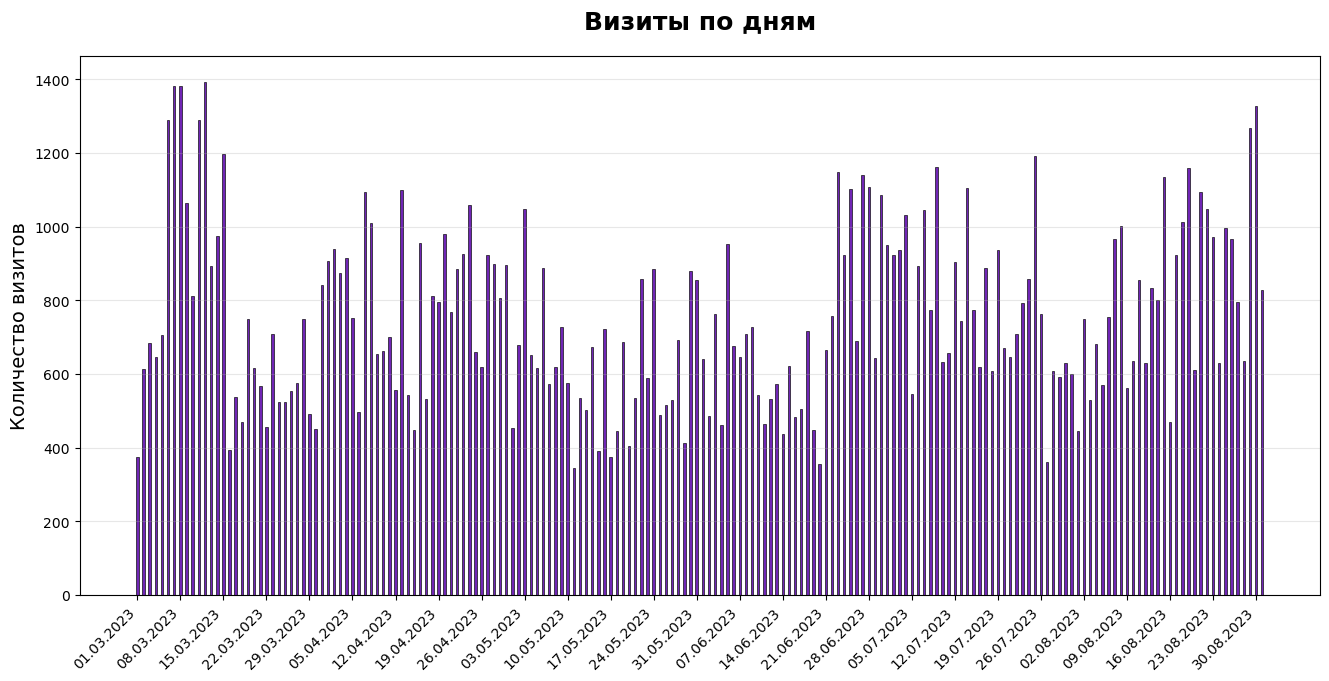

In [78]:
# Визиты по дням
visits_by_day = df_graf.copy()
visits_by_day = visits_by_day.groupby('date_group')['visits'].sum().reset_index()

plt.figure(figsize=(16, 7))
bars = plt.bar(
    visits_by_day['date_group'],
    visits_by_day['visits'],
    width=0.4,                
    alpha=0.9,
    color='#600ead',           
    edgecolor='black',
    linewidth=0.5
)
step = 7
plt.xticks(
    visits_by_day['date_group'][::step],
    visits_by_day['date_group'][::step].dt.strftime('%d.%m.%Y'),
    rotation=45,
    ha='right',
    fontsize=10
)
plt.title('Визиты по дням', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('', fontsize=14)
plt.ylabel('Количество визитов', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.savefig( d / 'final_visits.png', dpi=300, bbox_inches='tight')

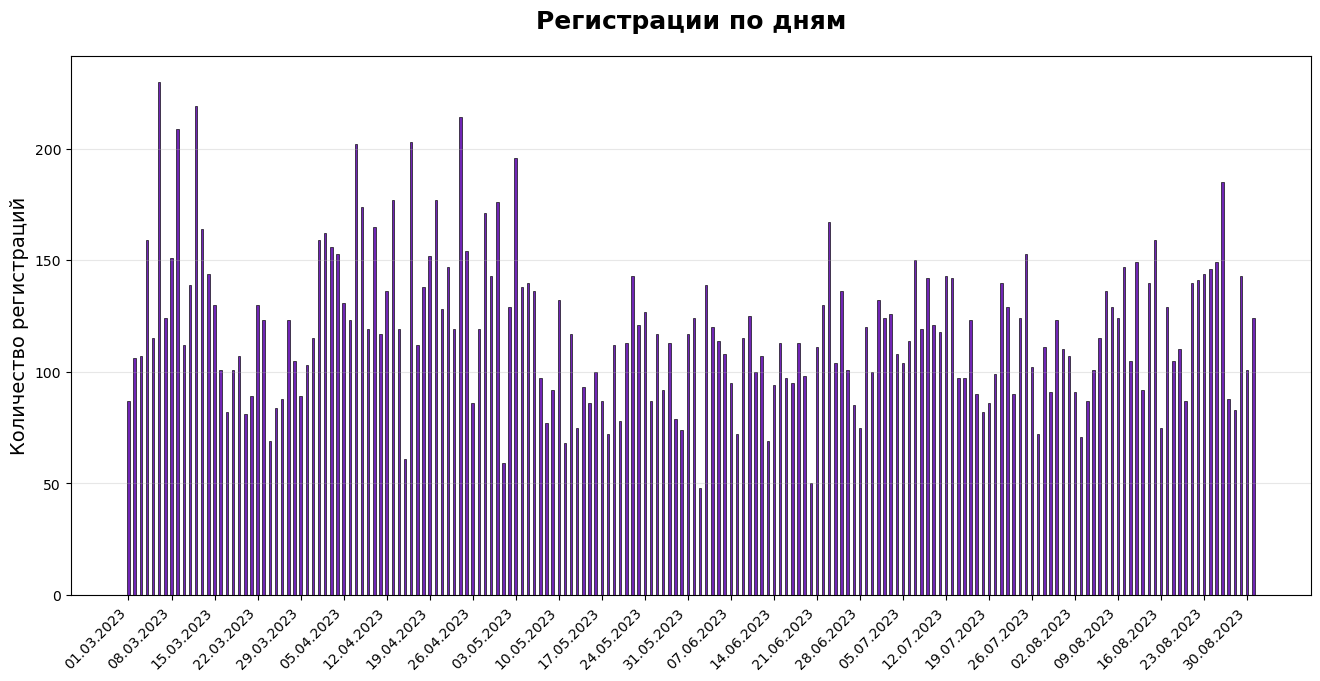

In [79]:
# Регистраций по дням
reg_by_day = df_graf.copy()
reg_by_day = reg_by_day.groupby('date_group')['registrations'].sum().reset_index()

plt.figure(figsize=(16, 7))
bars = plt.bar(
    reg_by_day['date_group'],
    reg_by_day['registrations'],
    width=0.4,                
    alpha=0.9,
    color='#600ead',           
    edgecolor='black',
    linewidth=0.5
)
step = 7
plt.xticks(
    visits_by_day['date_group'][::step],
    visits_by_day['date_group'][::step].dt.strftime('%d.%m.%Y'),
    rotation=45,
    ha='right',
    fontsize=10
)
plt.title('Регистрации по дням', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('', fontsize=14)
plt.ylabel('Количество регистраций', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.savefig( d / 'final_reg.png', dpi=300, bbox_inches='tight')


In [85]:
# Визиты по платформам
visits_platform = df_graf.copy()
# Преобразуем date_group в datetime (обязательно)
visits_platform['date_group'] = pd.to_datetime(visits_platform['date_group'])

platforms = ['web', 'android', 'ios']

# Фильтрация по платформам
filtered_result = visits_platform[visits_platform['platform'].isin(platforms)]

# 2. Агрегация: сумма визитов по дням и платформам
visits_by_day_platform = (
    filtered_result
    .groupby(['date_group', 'platform'])['visits']
    .sum()
    .unstack(fill_value=0)
    [platforms]  # Сохраняем порядок платформ
)

# 3. Явное преобразование индекса в DatetimeIndex (без freq)
visits_by_day_platform.index = pd.DatetimeIndex(visits_by_day_platform.index)

# 4. Проверка на пустые данные
if visits_by_day_platform.empty:
    raise ValueError("Нет данных для отображения: после фильтрации датафрейм пуст")


# 5. Создание графика
fig, ax = plt.subplots(figsize=(14, 8))

# Цвета для платформ
colors = ['#600ead', '#5fcc0c', '#eef52c']  # web, android, ios

# Построение столбчатой диаграммы (накопительная)
visits_by_day_platform.plot(
    kind='bar',
    stacked=True,
    color=colors,
    ax=ax,
    width=0.7,
    legend=True
)

# 6. Оформление подписей
ax.set_title(
    'Визиты по платформам (накопительно, по дням)',
    fontsize=18,
    fontweight='bold',
    pad=20
)
ax.set_xlabel('Дата', fontsize=14)
ax.set_ylabel('Количество визитов', fontsize=14)


# Легенда
ax.legend(title='Платформа', fontsize=12, title_fontsize=12)


# Сетка по оси Y
ax.grid(axis='y', alpha=0.3)


# 7. Настройка меток оси X (без зависимости от freq)
step = 7  # Шаг: отображать каждую 7‑ю дату

dates = visits_by_day_platform.index
date_labels = dates.strftime('%d.%m.%Y')  # Формат: «01.01.2025»


selected_positions = range(0, len(dates), step)
selected_labels = date_labels[::step]

ax.set_xticks(selected_positions)
ax.set_xticklabels(selected_labels, rotation=45, ha='right', fontsize=10)
plt.tight_layout()
plt.savefig('visits_platform.png', dpi=300, bbox_inches='tight')

SyntaxError: invalid syntax. Perhaps you forgot a comma? (813133239.py, line 49)